<a href="https://colab.research.google.com/github/litty2011/Image-Forgery-Detection-CNN/blob/master/friday_ver_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
from tensorflow import keras                                                   
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers                                            
import matplotlib.pyplot as plt
%matplotlib inline                                                              

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')                                                  
dataset_directory = '/content/gdrive/MyDrive/VTDAC'

Mounted at /content/gdrive


In [ ]:
!ls

drive  gdrive  sample_data


In [ ]:
#Set Numpy, Python and Tensorflow seeds to get consistent results.

seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [ ]:
# Get Names of all classes in REWIND
all_classes_names = os.listdir('/content/gdrive/MyDrive/VTDAC')       

In [ ]:
print(all_classes_names)

['original', 'tampered', 'train']


In [ ]:
image_height, image_width = 128, 128
max_images_per_class = 1000

dataset_directory = "/content/gdrive/MyDrive/VTDAC"
classes_list = ["original", "tampered"]

model_output_size = len(classes_list)

In [ ]:
print(list(enumerate(classes_list)))

[(0, 'original'), (1, 'tampered')]


In [ ]:
#Extract, Resize and Normalize Frames
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (128, 128))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
#Dataset Creation
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels

In [ ]:
#Calling the create_dataset method which returns features and labels.

features, labels = create_dataset()

Extracting Data of Class: original
Extracting Data of Class: tampered


In [ ]:
print(labels)

[0 0 0 ... 1 1 1]


In [ ]:
frameRate = cap.get(1) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    else:
        filename = "drive/MyDrive/OUTPUT/image_" +  str(int(frameId)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()

NameError: ignored

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
base_model = VGG16(                           
    input_tensor = Input(shape =(image_height, image_width, 3)),
    include_top = False,
    weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
frameRate = cap.get(1) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    else:
        filename = "drive/MyDrive/OUTPUT/image_" +  str(int(frameId)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()

NameError: ignored

In [ ]:
def create_model():
  head_model = base_model.output
  head_model = layers.Conv2D(128, (3,3), activation = 'relu', padding ='same') (head_model)
  head_model = layers.Conv2D(128, (3,3), activation = 'relu',padding ='same') (head_model)
  head_model = layers.BatchNormalization() (head_model)
  head_model = layers.MaxPooling2D(pool_size = (2, 2)) (head_model)
  head_model = layers.GlobalAveragePooling2D() (head_model)
  head_model = layers.Dense(256, activation = 'relu') (head_model)
  head_model = layers.BatchNormalization() (head_model)
  head_model = layers.Dense(model_output_size, activation = 'softmax') (head_model)
  model = keras.Model(inputs=base_model.input, outputs=head_model, name="sample_model")
  for layer in base_model.layers:
	  layer.trainable = False  
  return model

In [ ]:
# Calling the create_model method
model = create_model()

In [ ]:
model.summary()

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)      

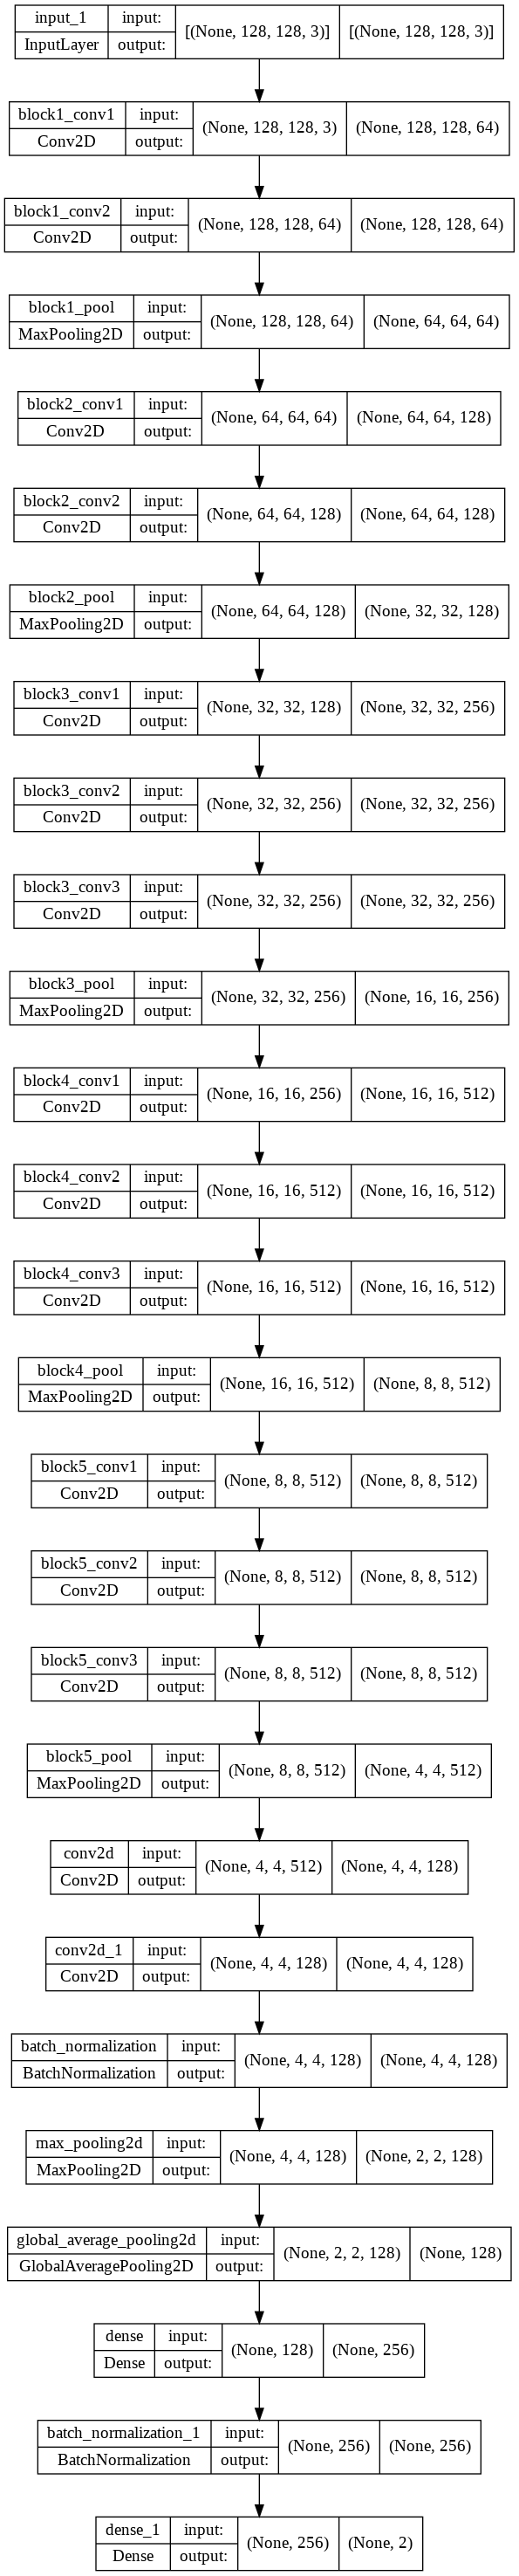

In [ ]:
#Check Model’s Structure:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [ ]:
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 10 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/30
120/120 [==============================] - 19s 49ms/step - loss: 0.5564 - accuracy: 0.7608 - val_loss: 0.4892 - val_accuracy: 0.7500
Epoch 2/30
120/120 [==============================] - 4s 32ms/step - loss: 0.2913 - accuracy: 0.8767 - val_loss: 0.3152 - val_accuracy: 0.8833
Epoch 3/30
120/120 [==============================] - 4s 30ms/step - loss: 0.2300 - accuracy: 0.9017 - val_loss: 0.2133 - val_accuracy: 0.9267
Epoch 4/30
120/120 [==============================] - 3s 29ms/step - loss: 0.1698 - accuracy: 0.9342 - val_loss: 0.5076 - val_accuracy: 0.8167
Epoch 5/30
120/120 [==============================] - 3s 29ms/step - loss: 0.1874 - accuracy: 0.9225 - val_loss: 0.3414 - val_accuracy: 0.8700
Epoch 6/30
120/120 [==============================] - 3s 29ms/step - loss: 0.1196 - accuracy: 0.9517 - val_loss: 0.6130 - val_accuracy: 0.8000
Epoch 7/30
120/120 [==============================] - 4s 30ms/step - loss: 0.1282 - accuracy: 0.9500 - val_loss: 0.2224 - val_accuracy: 0.930

In [ ]:
model_evaluation_history = model.evaluate(features_train, labels_train)  
model_evaluation_history = model.evaluate(features_test, labels_test)  

16/16 [==============================] - 2s 163ms/step - loss: 0.9038 - accuracy: 0.8200


In [ ]:
model.save('friday_version_2.1.h5') 

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()
  

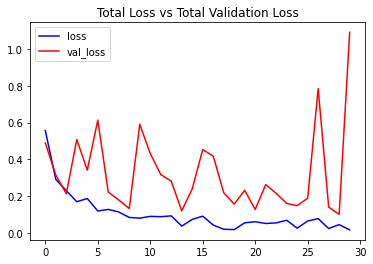

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

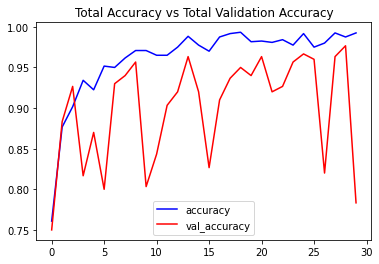

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
import os
import pandas
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import numpy as np
from keras.models import load_model

#vid_name = input("\nEnter the name of video: ")
#vid_src = open(r"D:/Users/Admin/Desktop/train/"+vid_name +".mp4")
#vid_src = "D:\Users\Admin\Desktop\train\\"+vid_name +".mp4"
#vid=[]
frames_list = []
#01_original.avi
#test1.mp4
cap = cv2.VideoCapture("o2.mp4")
frame_num = 0
image_num = 0
while cap.isOpened():
  ret, frame = cap.read()
  if ret:
    if frame_num % (30// 3) == 0:
      image_num += 1
      #vid.append(frame)
  else:
    break
  frame_num += 1
 
  cap.release()
print(len(frame))
resized_frame = cv2.resize(frame, (128, 128))
normalized_frame = resized_frame / 255
        
 # Appending the normalized frame into the frames list
frames_list.append(normalized_frame)
    
x_test = np.array(frames_list) #vid
print(x_test)
print("\nPredicting !! ")
model = load_model("friday_version_2.1.h5")
output = model.predict(x_test)
output = output.reshape((-1))
print(output)
results = []
#for i in output:
#    if i>0.5:
#        results.append(1)
#    else:
#        results.append(0)


if(output[0]>0.5 and output[1]<0.5):
  results.append(0)
else:
  results.append(1)   
no_of_forged = sum(results)
print(no_of_forged)       
if no_of_forged <1:
    print("\nThe video is not forged")
    
else:
    print("\nThe video is forged")

352
[[[[0.51372549 0.63137255 0.72941176]
   [0.54117647 0.65882353 0.75686275]
   [0.54901961 0.66666667 0.76470588]
   ...
   [0.05098039 0.10196078 0.07843137]
   [0.01176471 0.07843137 0.03137255]
   [0.01960784 0.0627451  0.09411765]]

  [[0.52941176 0.64705882 0.74509804]
   [0.54117647 0.65882353 0.75686275]
   [0.54117647 0.65882353 0.75294118]
   ...
   [0.02745098 0.07843137 0.05490196]
   [0.03921569 0.09019608 0.05490196]
   [0.00784314 0.04705882 0.05098039]]

  [[0.54509804 0.6627451  0.76078431]
   [0.54117647 0.65882353 0.75686275]
   [0.54509804 0.6627451  0.76078431]
   ...
   [0.05098039 0.10196078 0.07843137]
   [0.0745098  0.12156863 0.09019608]
   [0.08235294 0.11764706 0.09411765]]

  ...

  [[0.95686275 0.99215686 0.96862745]
   [0.96862745 0.99607843 0.96862745]
   [0.98823529 0.99607843 0.96862745]
   ...
   [0.11764706 0.23137255 0.28627451]
   [0.10196078 0.21568627 0.27058824]
   [0.05882353 0.17254902 0.22745098]]

  [[0.95686275 0.98823529 0.97647059]
   

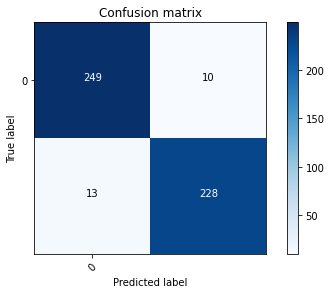

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(features_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(labels_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1)) 